In [68]:
from __future__ import print_function
%matplotlib inline
import geopandas as gpd
import numpy as np
from censusAPI import myAPI
import pandas as pd
import io
import shapely
from geopandas.tools import sjoin
from geopandas import GeoDataFrame
from matplotlib import pyplot as plt
import os
import zipfile
import json
from fiona.crs import from_epsg
import sys
try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib
import requests

# Census Geographies
census tracts, census blocks, Public Use Microdata Areas (PUMAs) <br>
Each PUMA contains at least 100,000 people. PUMAs do not overlap, and are contained within a single state.



# 1.1 download the NYC Public Use Microdata Areas (PUMA) geometry from the NYC Open Data API and read it in with geopandas

In [2]:
#unpack pluto dataframe in PUIDATA
puidata = os.getenv("PUIDATA")
if not puidata or puidata == '/nfshome/sjs909/PUIdata':
    puidata = '/nfshome/sjs909/PUIDATA'

os.environ["PUIDATA"] = puidata
os.environ["PUIDATA"]

'/nfshome/sjs909/PUIDATA'

In [3]:
with zipfile.ZipFile("%s/Public Use Microdata Areas (PUMA).zip"%os.getenv("PUIDATA"),"r") as zip_ref:
    zip_ref.extractall("PUMAdir")

In [4]:
#Move into PUIDATA
os.rename("/nfshome/sjs909/PUI2018/HW7_sjs909/PUMAdir", "/nfshome/sjs909/PUIDATA/PUMAdir")

OSError: [Errno 39] Directory not empty: '/nfshome/sjs909/PUI2018/HW7_sjs909/PUMAdir' -> '/nfshome/sjs909/PUIDATA/PUMAdir'

In [5]:
# read in the shapefile
PUMAShape = gpd.GeoDataFrame.from_file('%s/PUMAdir/geo_export_6dc93837-8056-4516-82d7-c7f1aaa89882.shp'%os.getenv("PUIDATA"))

In [6]:
PUMAShape.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [7]:
PUMAShape.crs

{'init': 'epsg:4326'}

# 1.2 plot the PUMA NYC regions

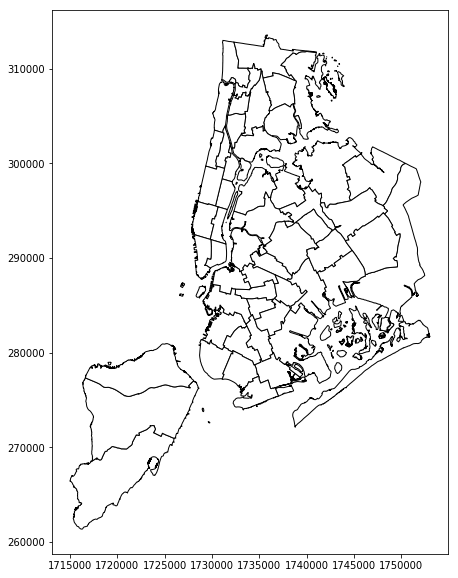

In [8]:
PUMAShape.crs = from_epsg(4326)
naec = '+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs'
PUMAShape.to_crs(naec).plot(color='white', edgecolor='black',figsize=(10,10))

**Caption** <br>This is a map of the Public Use Microdata Areas (PUMAs) for the NYC region. Each PUMA contains at least 100,000 people

# 2. American Fact Finder data on percentage of houses with broadband internet access

In [ ]:
# Manually downloaded and saved into PUIDATA
with zipfile.ZipFile("%s/aff_download.zip"%os.getenv("PUIDATA"),"r") as zip_ref:
    zip_ref.extractall('aff_download')

In [ ]:
#Move 
os.rename("/nfshome/sjs909/PUI2018/HW7_sjs909/aff_download", "/nfshome/sjs909/PUIDATA/aff_download")

In [9]:
pumaBB =  pd.read_csv("%s/aff_download/ACS_16_1YR_B28002_with_ann.csv"%os.getenv("PUIDATA"))

In [ ]:
pumaBB.head()

In [10]:
!pip install requests

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [12]:
affkeys = np.array(list(aff1y['variables'].keys()))

In [13]:
affkeys

array(['C24010_016E', 'B19001G_004E', 'B08203_002E', ..., 'B21001D_001E',
       'B17018_015E', 'B27007_057E'], 
      dtype='<U14')

In [14]:
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL')]

In [15]:
# we want total number of households, and number of households with broadband access
# we will use Estimate!!Total!!With an Internet subscription!!Broadband of any type'
#keyword for the number of households
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

In [ ]:
# Now we use this variable name to extract the relevant data with the ACS API

In [16]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [17]:
keyNHH = 'B28002_001E'
aff1y['variables'][keyNHH]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [18]:
#getting the first row of the table: the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNHH +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaHH = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaHH.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [19]:
# Merge the dataframes on NAME

both = pumaBB.merge(pumaHH, on ='NAME')

In [ ]:
both.head()

In [ ]:
both.columns

In [20]:
both.drop(['state_x','Unnamed: 4_x','state_y','public use microdata area_y','Unnamed: 4_y'],inplace=True, axis = 1 )

In [21]:
both = both.rename(columns={'public use microdata area_x':'geoID','B28002_004E':'Broadband','B28002_001E':'HH' })

# 2.2 Create a feature (a column, a series) with the ratio of percentage of households with broadband access

In [22]:
both['pcBB'] = (both['Broadband'] / both['HH'])*100

In [ ]:
both.head()

# 2.3 Now compare it with the AFF published "percentage of households with broadband access" which is a feature available through their website but that cannot be downloaded directly from the API. It compiled by AFF the same way we did above

In [ ]:
# Manually downloaded and saved into PUIDATA
with zipfile.ZipFile("%s/GCT2801.zip"%os.getenv("PUIDATA"),"r") as zip_ref:
    zip_ref.extractall('GCT2801')

In [ ]:
#Move 
os.rename("/nfshome/sjs909/PUI2018/HW7_sjs909/GCT2801", "/nfshome/sjs909/PUIDATA/GCT2801")

In [23]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/GCT2801/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])
#drop the first row with weird double header
bbpc.drop(0, inplace=True)
bbpc['GCT_STUB.target-geo-id2'] = bbpc['GCT_STUB.target-geo-id2'].astype(int)

In [24]:
bbpc = bbpc.rename(columns={'GCT_STUB.target-geo-id2': 'geoID','HC01':'Percent','HC02':'Margin of Error' })

In [25]:
# get the geo ID without initial three digits
bbpc["geoID"] = bbpc.geoID - 3600000

In [26]:
# merge on the puma id
checkdf = both.merge(bbpc, on ='geoID')

In [ ]:
checkdf.describe()

In [ ]:
checkdf

In [27]:
checkdf["diff"] = np.abs(checkdf["pcBB"] - checkdf["Percent"].astype(float))

checkdf.describe()

,Broadband,geoID,HH,pcBB,diff
count,145.000000,145.000000,145.000000,145.000000,145.000000
mean,40603.862069,2826.827586,49717.613793,81.845478,0.026217
std,11787.178809,1210.054822,13579.838124,7.063369,0.014480
min,17925.000000,100.000000,28984.000000,54.932945,0.000178
25%,32736.000000,1900.000000,40473.000000,77.770257,0.012252
50%,37294.000000,3208.000000,46654.000000,82.826141,0.027230
75%,44681.000000,3809.000000,56295.000000,87.305077,0.039090
max,102520.000000,4114.000000,111507.000000,93.404143,0.049872


# #3 Plot a choropleth of NYC broadband access

3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

In [28]:
PUMAShape.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [29]:
# make sure they are the same type!!
PUMAShape['puma'] = PUMAShape['puma'].astype(int)

In [ ]:
PUMAShape = PUMAShape.rename(columns={'puma':'geoID'})

In [30]:
ShapeData = PUMAShape.merge(checkdf, right_on="geoID", 
                     left_on="puma")

In [31]:
ShapeData.head()

,puma,shape_area,shape_leng,geometry,Broadband,NAME,geoID,HH,pcBB,Percent,Margin of Error,diff
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",3701,42158,84.275820,84.3,2.6,0.024180
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",3702,49817,68.310015,68.3,3.7,0.010015
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",3703,44329,82.826141,82.8,3.2,0.026141
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,3704,44476,72.553737,72.6,3.6,0.046263
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,4015,55953,78.778618,78.8,2.9,0.021382


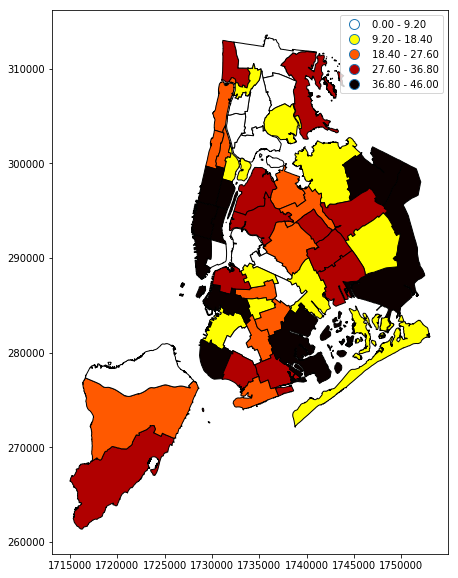

In [49]:
ShapeData.crs = from_epsg(4326)
naec = '+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs'
ShapeData.to_crs(naec).plot(column='Percent', edgecolor='black',figsize=(10,10),legend=True, cmap = 'hot_r', scheme = 'equal_interval')

Here is a cloropleth of the percentage of households with broadband access in the NYC area broken down by Public Use Microdata Areas. Notice where the areas are darker, there is a higher percent of internet coverage. The inequality is interesting where the outter boughroughs such as the Bronx and Queens have much lower percent of internet.

# 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.


In [51]:
#Move 
os.rename("/nfshome/sjs909/PUI2018/PUI2018_fb55/HW7_fb55/linkNYClocations.csv", "/nfshome/sjs909/PUIDATA/linkNYClocations.csv")


FileNotFoundError: [Errno 2] No such file or directory: '/nfshome/sjs909/PUI2018/PUI2018_fb55/HW7_fb55/linkNYClocations.csv' -> '/nfshome/sjs909/PUIDATA/linkNYClocations.csv'

In [52]:
linkNYC =  pd.read_csv("%s/linkNYClocations.csv"%os.getenv("PUIDATA"))

In [59]:
linkNYC.drop(['Unnamed: 0'],axis=1,inplace=True )

In [61]:
linkNYC.shape

(1414, 4)

Combine long lat into a column like you did in the lab to greate a "geometry" column for the dataframe, then convert the dataframe into a GeoDataFrame linkNYC and set native coordinates frame to lat/lon as you did in the lab

In [63]:
# combine lat and lon to one column
linkNYC['lonlat']=list(zip(linkNYC.longitude,linkNYC.latitude))

In [65]:
# Create Point Geometry for based on lonlat column
linkNYC['geometry']=linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


Intersect the two geometries

In [71]:
linkNYC = GeoDataFrame(linkNYC)

In [74]:
linkNYC.crs = from_epsg(4326)
ShapeData.crs

{'init': 'epsg:4326', 'no_defs': True}

In [75]:
linkNYC_ft = linkNYC.to_crs(epsg=2263)
ShapeData_ft = ShapeData.to_crs(epsg=2263)

In [95]:
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [284]:
Joined = sjoin(linkNYC_ft, ShapeData_ft)

In [285]:
Joined.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry,index_right,puma,shape_area,shape_leng
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (1000196.411360609 194918.1045344363),29,4001,1.149292e+08,74076.375782
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (1000284.976955119 194872.4991186759),29,4001,1.149292e+08,74076.375782
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (1000265.48686938 195013.900946364),29,4001,1.149292e+08,74076.375782
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (1000076.658138533 196154.157733508),29,4001,1.149292e+08,74076.375782
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (997155.0239397929 204558.4761382252),29,4001,1.149292e+08,74076.375782


In [98]:
linkNYC.crs = from_epsg(4326)
naec = '+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs'

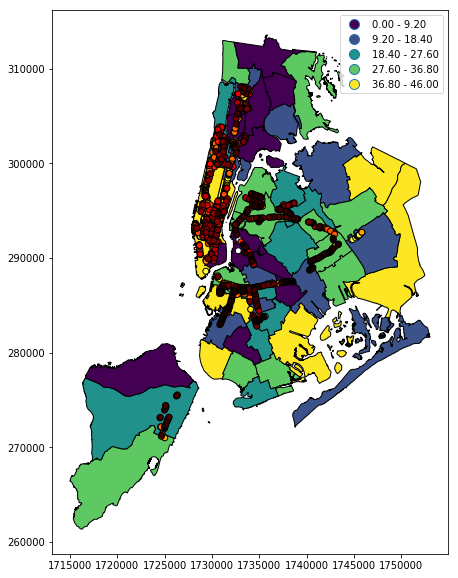

In [221]:
base = ShapeData.to_crs(naec).plot(column='Percent', edgecolor='black',figsize=(10,10),legend=True, cmap = 'viridis', scheme = 'equal_interval')

linkNYC.to_crs(naec).plot(edgecolor='black',figsize=(10,10),legend=True,ax=base, cmap = 'hot_r', scheme = 'equal_interval')


Here is the same map of internet broadband coverage broken down by PUMA, now with the exact location of the linkNYC kiosks added. It seems that these are distributed rather equally throuhought Manhattan, however the upper Bronx, upper Staten Island, Lower Brooklyn and outter Queens do not have any. Furthermore, these areas are not well covered by internet.

# 5 Find the number of linkNYC locations per person by PUMA

5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF

In [99]:
keyNtp = 'B00001_001E'
aff1y['variables'][keyNtp]

{'attributes': 'B00001_001EA',
 'concept': 'UNWEIGHTED SAMPLE COUNT OF THE POPULATION',
 'group': 'B00001',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [ ]:
# Now we use this variable name to extract the relevant data with the ACS API

In [240]:
# getting the population
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNtp +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumatp = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))


In [235]:
pumatp.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [241]:
pumatp = pumatp.rename(columns={'public use microdata area':'puma'})

In [370]:
# Now lets merge it into your ShapeData file
popShapeFile = ShapeData.merge(pumatp, on='puma')
popShapeFile.head()

,puma,shape_area,shape_leng,geometry,Broadband,NAME_x,geoID,HH,pcBB,Percent,Margin of Error,diff,B00001_001E,NAME_y,state,Unnamed: 4
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",3701,42158,84.275820,84.3,2.6,0.024180,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,NaN
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",3702,49817,68.310015,68.3,3.7,0.010015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,NaN
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",3703,44329,82.826141,82.8,3.2,0.026141,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,NaN
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,3704,44476,72.553737,72.6,3.6,0.046263,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,NaN
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,4015,55953,78.778618,78.8,2.9,0.021382,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,NaN


In [279]:
# 5.2 find the number of station per 100 people per PUMA

Important you can do this with an sjoin(). But sjoin() should not be used with lat/lon coordinates cause they are not "flat coordinates". Since spattial joins are done in cartesian geometry the only coordinate systems suitable to spatial joins are flat coordinate plane systems, which in the NYC area is 2263. So before you proceed to the sjoin you have to convert both pumashp and linkNYC to 2263 (for example with GeoDataFrame method .to_crs(epsg=...) )

In [320]:
# convert the popShapeFile and linkNYC to 2263
popShapeFile = GeoDataFrame(popShapeFile)
linkNYC = GeoDataFrame(linkNYC)
popShapeFile.crs = from_epsg(4326)
linkNYC.crs = from_epsg(4326)

In [322]:
popShapeFile_ft = popShapeFile.to_crs(epsg=2263)
linkNYC_ft = linkNYC.to_crs(epsg=2263)

In [323]:
Joined = sjoin(popShapeFile_ft, linkNYC_ft)

In [324]:
Joined.head()

,puma,shape_area,shape_leng,geometry,Broadband,NAME_x,geoID,HH,pcBB,Percent,...,B00001_001E,NAME_y,state,Unnamed: 4,index_right,link_site,longitude,date_link_,latitude,lonlat
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",35529,"NYC-Bronx Community District 8--Riverdale, Fie...",3701,42158,84.275820,84.3,...,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,NaN,1286,bx-08-145850,-73.902101,2017-06-10,40.868698,"(-73.9021009, 40.86869849)"
4,4015,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,...",44079,NYC-Brooklyn Community District 14--Flatbush &...,4015,55953,78.778618,78.8,...,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,NaN,1218,bk-14-145758,-73.957990,2017-03-03,40.643941,"(-73.95799026, 40.64394086)"
4,4015,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,...",44079,NYC-Brooklyn Community District 14--Flatbush &...,4015,55953,78.778618,78.8,...,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,NaN,1216,bk-14-145789,-73.958144,2017-03-06,40.645262,"(-73.95814408, 40.6452617)"
4,4015,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,...",44079,NYC-Brooklyn Community District 14--Flatbush &...,4015,55953,78.778618,78.8,...,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,NaN,1215,bk-14-145814,-73.958203,2017-04-08,40.646179,"(-73.95820347, 40.64617918)"
6,3705,1.224951e+08,68657.316149,"POLYGON ((1019225.58178711 245263.8524169383, ...",40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",3705,58706,69.425612,69.4,...,2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,NaN,927,bx-06-118922,-73.898221,2017-10-20,40.846926,"(-73.898220556, 40.8469261747)"


create a geodataframe with a spatial join and use groupby to count the number of linkNYC in each PUMA

In [325]:
linkpp = sjoin(popShapeFile_ft, linkNYC_ft).groupby('puma').count()
linkpp.head()

,shape_area,shape_leng,geometry,Broadband,NAME_x,geoID,HH,pcBB,Percent,Margin of Error,...,B00001_001E,NAME_y,state,Unnamed: 4,index_right,link_site,longitude,date_link_,latitude,lonlat
puma,,,,,,,,,,,,,,,,,,,,,
3701,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,1,1,1,1,1
3705,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,1,1,1,1,1
3706,20,20,20,20,20,20,20,20,20,20,...,20,20,20,0,20,20,20,20,20,20
3707,29,29,29,29,29,29,29,29,29,29,...,29,29,29,0,29,29,29,29,29,29
3708,19,19,19,19,19,19,19,19,19,19,...,19,19,19,0,19,19,19,19,19,19


In [327]:
linkpp.columns

Index(['shape_area', 'shape_leng', 'geometry', 'Broadband', 'NAME_x', 'geoID',
       'HH', 'pcBB', 'Percent', 'Margin of Error', 'diff', 'B00001_001E',
       'NAME_y', 'state', 'Unnamed: 4', 'index_right', 'link_site',
       'longitude', 'date_link_', 'latitude', 'lonlat'],
      dtype='object')

In [355]:
GroupNYC = linkpp.drop(['shape_area', 'shape_leng', 'geometry', 'Broadband', 'NAME_x', 'geoID',
       'HH', 'pcBB', 'Percent', 'Margin of Error', 'diff', 'B00001_001E',
       'NAME_y', 'state', 'Unnamed: 4', 'index_right',
       'longitude', 'date_link_', 'latitude', 'lonlat'],axis=1)

In [358]:
GroupNYC.head()

,puma,link_site
0,3701,1
1,3705,1
2,3706,20
3,3707,29
4,3708,19


count the number of linkNYC in each PUMA

In [357]:
GroupNYC.reset_index(level=0, inplace=True)

In [335]:
#GroupNYC = GroupNYC.rename(columns={'puma':'puma1'})

finally merge back into the pumashp. Make sure you use the correct scheme for merging: you want to have all the PUMAs, not only the ones that have linkNYC in them in the final geoDF

In [371]:
NYCLinkCountandShape = popShapeFile.merge(GroupNYC, on="puma",how='outer')

In [373]:
NYCLinkCountandShape["linkNYCp100p"] = (NYCLinkCountandShape["link_site"]/NYCLinkCountandShape["B00001_001E"])*100

In [374]:
NYCLinkCountandShape["linkNYCp100p"].describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%            NaN
50%            NaN
75%            NaN
max      15.141540
Name: linkNYCp100p, dtype: float64

In [380]:
NYCLinkCountandShape = NYCLinkCountandShape.drop('Unnamed: 4',axis=1)

ValueError: labels ['Unnamed: 4'] not contained in axis

In [383]:
NYCLinkCountandShape.rename(columns={'B00001_001E':'Population'},inplace=True)

In [384]:
NYCLinkCountandShape.head()

,puma,shape_area,shape_leng,geometry,Broadband,NAME_x,geoID,HH,pcBB,Percent,Margin of Error,diff,Population,NAME_y,state,link_site,linkNYCp100p
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",3701,42158,84.275820,84.3,2.6,0.024180,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,1.0,0.065920
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",3702,49817,68.310015,68.3,3.7,0.010015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,NaN,NaN
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",3703,44329,82.826141,82.8,3.2,0.026141,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,NaN,NaN
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,3704,44476,72.553737,72.6,3.6,0.046263,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,NaN,NaN
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,4015,55953,78.778618,78.8,2.9,0.021382,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,3.0,0.119284


# at last, plot the linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals

In [385]:
NYCLinkCountandShape.crs = from_epsg(4326)
naec = '+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs'

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


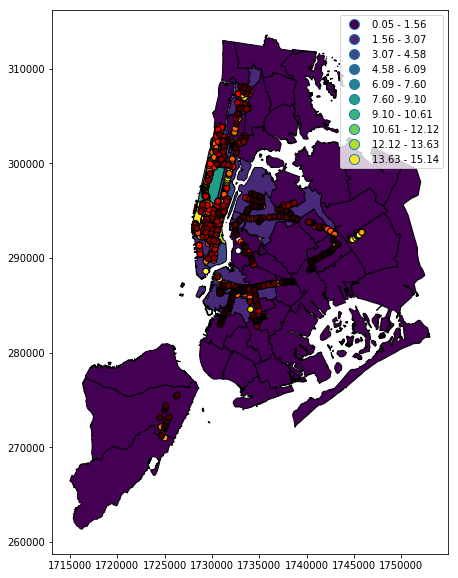

In [387]:
base = NYCLinkCountandShape.to_crs(naec).plot(column='linkNYCp100p', edgecolor='black',k =10, figsize=(10,10),legend=True, cmap = 'viridis', scheme = 'equal_interval')

linkNYC.to_crs(naec).plot(edgecolor='black',figsize=(10,10),legend=True,ax=base, cmap = 'hot_r', scheme = 'equal_interval')


The final graph! Yay, this shows the population percentage per linkNYC location. It seems the highest concentration of population has the most amount of internet Kiosks.

In [ ]:
# From Rohunnybear

In [359]:
pumashplc =  popShapeFile_ft.merge(GroupNYC, on="puma",how='outer')


In [361]:
pumashplc.describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,puma,shape_area,shape_leng,Broadband,geoID,HH,pcBB,diff,B00001_001E,state,Unnamed: 4,link_site
count,55.000000,5.500000e+01,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.0,0.0,37.000000
mean,3936.218182,1.532632e+08,91547.959548,45287.254545,3936.218182,56633.272727,79.462797,0.027518,2138.618182,36.0,NaN,38.216216
std,149.997616,1.361440e+08,77522.481125,14410.514427,149.997616,14874.212875,7.548276,0.013269,699.237163,0.0,NaN,46.499782
min,3701.000000,3.984279e+07,34852.437966,27834.000000,3701.000000,37998.000000,54.932945,0.001693,1238.000000,36.0,NaN,1.000000
25%,3804.500000,7.498814e+07,48072.809133,35658.500000,3804.500000,45822.500000,74.772059,0.020397,1554.000000,36.0,NaN,NaN
50%,4005.000000,1.070001e+08,70492.955589,41578.000000,4005.000000,52591.000000,79.301693,0.027634,2004.000000,36.0,NaN,NaN
75%,4059.500000,1.692189e+08,98789.538654,50273.000000,4059.500000,62501.500000,85.127599,0.039522,2383.500000,36.0,NaN,NaN
max,4114.000000,6.760200e+08,412606.741739,102520.000000,4114.000000,111507.000000,93.030650,0.049841,4001.000000,36.0,NaN,230.000000


In [312]:
linkpp = GroupNYC.groupby('puma').count()

In [313]:
linkpp.reset_index(level=0, inplace=True)

In [314]:
linkpp.head() 

,puma,link_site
0,3701,1
1,3705,1
2,3706,20
3,3707,29
4,3708,19


In [315]:
linkpp['puma'] = linkpp['puma'].astype(int)

In [317]:
linkpp.crs = from_epsg(4326)
linkpp_ft = linkpp.to_crs(epsg=2263)

AttributeError: 'DataFrame' object has no attribute 'to_crs'

In [ ]:
# Now we need to add this column to our popShapeFile

Make sure you use the correct scheme for merging: you want to have all the PUMAs, not only the ones that have linkNYC in them in the final geoDF

In [304]:
linkpp = GeoDataFrame(linkpp)

In [347]:
geoDF = linkpp.merge(popShapeFile, left_on="puma",right_on="puma",how='inner')

KeyError: 'puma'

In [300]:
popShapeFile.describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,puma,shape_area,shape_leng,Broadband,geoID,HH,pcBB,diff,B00001_001E,state,Unnamed: 4
count,55.000000,5.500000e+01,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.0,0.0
mean,3936.218182,1.532632e+08,91547.959548,45287.254545,3936.218182,56633.272727,79.462797,0.027518,2138.618182,36.0,NaN
std,149.997616,1.361440e+08,77522.481125,14410.514427,149.997616,14874.212875,7.548276,0.013269,699.237163,0.0,NaN
min,3701.000000,3.984279e+07,34852.437966,27834.000000,3701.000000,37998.000000,54.932945,0.001693,1238.000000,36.0,NaN
25%,3804.500000,7.498814e+07,48072.809133,35658.500000,3804.500000,45822.500000,74.772059,0.020397,1554.000000,36.0,NaN
50%,4005.000000,1.070001e+08,70492.955589,41578.000000,4005.000000,52591.000000,79.301693,0.027634,2004.000000,36.0,NaN
75%,4059.500000,1.692189e+08,98789.538654,50273.000000,4059.500000,62501.500000,85.127599,0.039522,2383.500000,36.0,NaN
max,4114.000000,6.760200e+08,412606.741739,102520.000000,4114.000000,111507.000000,93.030650,0.049841,4001.000000,36.0,NaN


In [303]:
geoDF.describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,puma,link_site,shape_area,shape_leng,Broadband,geoID,HH,pcBB,diff,B00001_001E,state,Unnamed: 4
count,37.000000,37.000000,3.700000e+01,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.0,0.0
mean,3917.000000,38.216216,1.207017e+08,67810.760710,46463.702703,3917.000000,58130.432432,79.177482,0.028246,1938.243243,36.0,NaN
std,143.587952,46.499782,1.303485e+08,34544.020794,16151.491644,143.587952,16086.079754,7.932258,0.012603,549.368193,0.0,NaN
min,3701.000000,1.000000,3.984279e+07,34852.437966,30110.000000,3701.000000,40473.000000,54.932945,0.002200,1238.000000,36.0,NaN
25%,3804.000000,12.000000,6.184965e+07,44724.499267,35788.000000,3804.000000,46654.000000,74.810319,0.020467,1519.000000,36.0,NaN
50%,4001.000000,25.000000,8.560261e+07,56323.365530,41578.000000,4001.000000,52591.000000,78.778618,0.027230,1846.000000,36.0,NaN
75%,4011.000000,40.000000,1.171050e+08,74076.375782,49039.000000,4011.000000,66037.000000,84.939550,0.039550,2149.000000,36.0,NaN
max,4112.000000,230.000000,6.760200e+08,194764.602625,102520.000000,4112.000000,111507.000000,93.030650,0.049841,3940.000000,36.0,NaN


In [ ]:
# Get count of link_sites

In [ ]:
#Now we have the count of link_sites and the population columns
#make a new column for the number of sites per 100 people
# first we divide pop in each puma by 100
PopandShape["onehundredp"] = PopandShape.B00001_001E / 100
# second we divide number of stations per 100 people
PopandShape["linkNYCp100p"] = PopandShape.onehundredp / PopShape.link_site

In [ ]:
REFRESH!

In [242]:
pumatp['puma'] = pumatp['puma'].astype(int)

In [243]:
# add population to shape data
PopandShape = ShapeData.merge(pumatp, on="puma")

In [274]:
PopandShape.head()

,puma,shape_area,shape_leng,geometry,Broadband,NAME_x,geoID,HH,pcBB,Percent,Margin of Error,diff,B00001_001E,NAME_y,state,Unnamed: 4
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",3701,42158,84.275820,84.3,2.6,0.024180,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,NaN
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",3702,49817,68.310015,68.3,3.7,0.010015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,NaN
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",3703,44329,82.826141,82.8,3.2,0.026141,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,NaN
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,3704,44476,72.553737,72.6,3.6,0.046263,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,NaN
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,4015,55953,78.778618,78.8,2.9,0.021382,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,NaN


In [ ]:
# now we need to add the linkNYC data

In [74]:
linkNYC.crs = from_epsg(4326)
PopandShape.crs

{'init': 'epsg:4326', 'no_defs': True}

In [246]:
linkNYC_ft = linkNYC.to_crs(epsg=2263)
PopandShape_ft = PopandShape.to_crs(epsg=2263)

In [259]:
Joined = sjoin(linkNYC_ft, PopandShape_ft)

In [252]:
Joined.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry,index_right,puma,shape_area,shape_leng,...,geoID,HH,pcBB,Percent,Margin of Error,diff,B00001_001E,NAME_y,state,Unnamed: 4
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (1000196.411360609 194918.1045344363),29,4001,1.149292e+08,74076.375782,...,4001,66037,70.631616,70.6,2.8,0.031616,2428,NYC-Brooklyn Community District 1--Greenpoint ...,36,NaN
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (1000284.976955119 194872.4991186759),29,4001,1.149292e+08,74076.375782,...,4001,66037,70.631616,70.6,2.8,0.031616,2428,NYC-Brooklyn Community District 1--Greenpoint ...,36,NaN
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (1000265.48686938 195013.900946364),29,4001,1.149292e+08,74076.375782,...,4001,66037,70.631616,70.6,2.8,0.031616,2428,NYC-Brooklyn Community District 1--Greenpoint ...,36,NaN
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (1000076.658138533 196154.157733508),29,4001,1.149292e+08,74076.375782,...,4001,66037,70.631616,70.6,2.8,0.031616,2428,NYC-Brooklyn Community District 1--Greenpoint ...,36,NaN
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (997155.0239397929 204558.4761382252),29,4001,1.149292e+08,74076.375782,...,4001,66037,70.631616,70.6,2.8,0.031616,2428,NYC-Brooklyn Community District 1--Greenpoint ...,36,NaN


In [275]:
#Now we have the count of link_sites and the population columns
#make a new column for the number of sites per 100 people
# first we divide pop in each puma by 100
PopandShape["onehundredp"] = PopandShape.B00001_001E / 100
# second we divide number of stations per 100 people
PopandShape["linkNYCp100p"] = PopandShape.onehundredp / PopShape.link_site

In [277]:
PopandShape.head()

,puma,shape_area,shape_leng,geometry,Broadband,NAME_x,geoID,HH,pcBB,Percent,Margin of Error,diff,B00001_001E,NAME_y,state,Unnamed: 4,onehundredp,linkNYCp100p
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",3701,42158,84.275820,84.3,2.6,0.024180,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,NaN,15.17,15.170000
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",3702,49817,68.310015,68.3,3.7,0.010015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,NaN,19.59,6.530000
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",3703,44329,82.826141,82.8,3.2,0.026141,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,NaN,13.05,13.050000
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,3704,44476,72.553737,72.6,3.6,0.046263,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,NaN,18.82,0.941000
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,4015,55953,78.778618,78.8,2.9,0.021382,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,NaN,25.15,0.867241


In [238]:
pumatp.head()

,B00001_001E,NAME,state,puma1,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


5.2 find the number of station per 100 people per PUMA

In [261]:
Joined.drop(['longitude', 'date_link_', 'latitude', 'lonlat',
       'geometry', 'index_right', 'shape_area', 'shape_leng',
       'Broadband', 'NAME_x', 'geoID', 'HH', 'pcBB', 'Percent',
       'Margin of Error', 'diff', 'NAME_y', 'B00001_001E','state',
       'Unnamed: 4'],axis=1, inplace=True)

In [262]:
Joined.columns

Index(['link_site', 'puma'], dtype='object')

count the number of linkNYC in each PUMA

In [263]:
linkpp = Joined.groupby('puma').count()

In [265]:
linkpp.reset_index(level=0, inplace=True)

In [278]:
linkpp.head() 

,puma,link_site
0,3701,1
1,3705,1
2,3706,20
3,3707,29
4,3708,19


In [269]:
ShapeData.head()

,puma,shape_area,shape_leng,geometry,Broadband,NAME,geoID,HH,pcBB,Percent,Margin of Error,diff
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",3701,42158,84.275820,84.3,2.6,0.024180
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",3702,49817,68.310015,68.3,3.7,0.010015
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",3703,44329,82.826141,82.8,3.2,0.026141
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,3704,44476,72.553737,72.6,3.6,0.046263
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,4015,55953,78.778618,78.8,2.9,0.021382


In [ ]:
# merge this with the ShapeData

In [268]:
linkpp['puma'] = linkpp['puma'].astype(int)

In [ ]:
NYCLinkandShape = ShapeData.merge(linkpp, on="puma")

In [273]:
PopShape.describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,puma,shape_area,shape_leng,Broadband,geoID,HH,pcBB,diff,link_site,B00001_001E,state,Unnamed: 4,onehundredp,linkNYCp100p
count,37.000000,3.700000e+01,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.0,0.0,37.000000,37.000000
mean,3917.000000,1.207017e+08,67810.760710,46463.702703,3917.000000,58130.432432,79.177482,0.028246,38.216216,1938.243243,36.0,NaN,19.382432,2.552896
std,143.587952,1.303485e+08,34544.020794,16151.491644,143.587952,16086.079754,7.932258,0.012603,46.499782,549.368193,0.0,NaN,5.493682,4.832502
min,3701.000000,3.984279e+07,34852.437966,30110.000000,3701.000000,40473.000000,54.932945,0.002200,1.000000,1238.000000,36.0,NaN,12.380000,0.066043
25%,3804.000000,6.184965e+07,44724.499267,35788.000000,3804.000000,46654.000000,74.810319,0.020467,12.000000,1519.000000,36.0,NaN,15.190000,0.533793
50%,4001.000000,8.560261e+07,56323.365530,41578.000000,4001.000000,52591.000000,78.778618,0.027230,25.000000,1846.000000,36.0,NaN,18.460000,0.769474
75%,4011.000000,1.171050e+08,74076.375782,49039.000000,4011.000000,66037.000000,84.939550,0.039550,40.000000,2149.000000,36.0,NaN,21.490000,1.857500
max,4112.000000,6.760200e+08,194764.602625,102520.000000,4112.000000,111507.000000,93.030650,0.049841,230.000000,3940.000000,36.0,NaN,39.400000,20.110000


In [197]:
linkpp.head()

,puma,link_site
0,3701,1
1,3705,1
2,3706,20
3,3707,29
4,3708,19


In [179]:
linkpp['puma'] = linkpp['puma'].astype(int)

In [229]:
NYCLinkandShape = ShapeData.merge(linkpp, on="puma")

In [116]:
pumatp = pumatp.rename(columns={'public use microdata area':'puma'})

In [190]:
pumatp['puma'] = pumatp['puma'].astype(int)

In [204]:
# lets merge this with population data 
PopShape = NYCLinkandPopShape.merge(pumatp, on="puma")

In [231]:
PopShape.describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,puma,shape_area,shape_leng,Broadband,geoID,HH,pcBB,diff,link_site,B00001_001E,state,Unnamed: 4,onehundredp,linkNYCp100p
count,37.000000,3.700000e+01,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.0,0.0,37.000000,37.000000
mean,3917.000000,1.207017e+08,67810.760710,46463.702703,3917.000000,58130.432432,79.177482,0.028246,38.216216,1938.243243,36.0,NaN,19.382432,2.552896
std,143.587952,1.303485e+08,34544.020794,16151.491644,143.587952,16086.079754,7.932258,0.012603,46.499782,549.368193,0.0,NaN,5.493682,4.832502
min,3701.000000,3.984279e+07,34852.437966,30110.000000,3701.000000,40473.000000,54.932945,0.002200,1.000000,1238.000000,36.0,NaN,12.380000,0.066043
25%,3804.000000,6.184965e+07,44724.499267,35788.000000,3804.000000,46654.000000,74.810319,0.020467,12.000000,1519.000000,36.0,NaN,15.190000,0.533793
50%,4001.000000,8.560261e+07,56323.365530,41578.000000,4001.000000,52591.000000,78.778618,0.027230,25.000000,1846.000000,36.0,NaN,18.460000,0.769474
75%,4011.000000,1.171050e+08,74076.375782,49039.000000,4011.000000,66037.000000,84.939550,0.039550,40.000000,2149.000000,36.0,NaN,21.490000,1.857500
max,4112.000000,6.760200e+08,194764.602625,102520.000000,4112.000000,111507.000000,93.030650,0.049841,230.000000,3940.000000,36.0,NaN,39.400000,20.110000


In [351]:
PopShape["linkNYCp100p"] = (PopShape["link_site"]/PopShape["B00001_001E"])*100

In [352]:
PopShape["linkNYCp100p"].describe()

count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%       0.538358
50%       1.299590
75%       1.873385
max      15.141540
Name: linkNYCp100p, dtype: float64

# at last, plot the linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals

In [216]:
PopShape.crs = from_epsg(4326)
naec = '+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs'

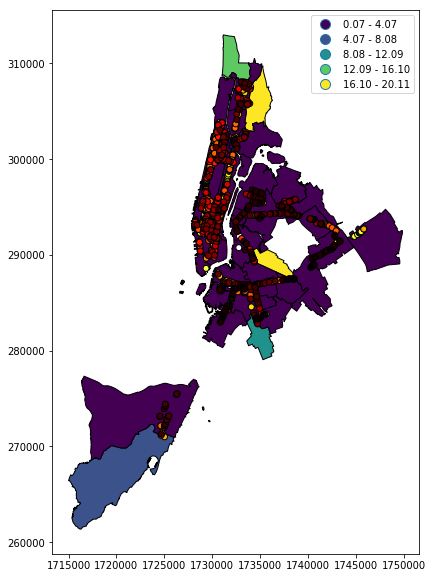

In [222]:
base = PopShape.to_crs(naec).plot(column='linkNYCp100p', edgecolor='black',figsize=(10,10),legend=True, cmap = 'viridis', scheme = 'equal_interval')

linkNYC.to_crs(naec).plot(edgecolor='black',figsize=(10,10),legend=True,ax=base, cmap = 'hot_r', scheme = 'equal_interval')


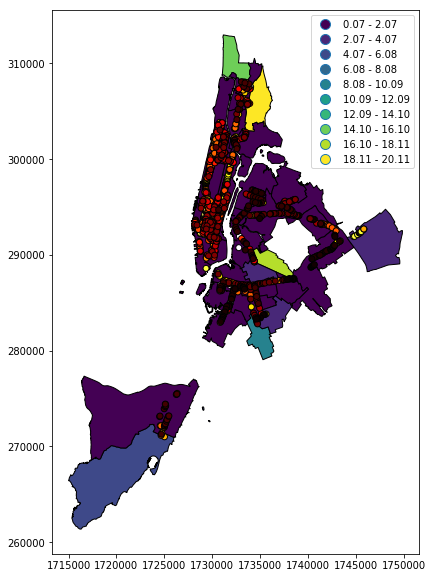

In [346]:
base = PopShape.to_crs(naec).plot(column='linkNYCp100p', edgecolor='black',figsize=(10,10),k=10,legend=True, cmap = 'viridis', scheme = 'equal_interval')

linkNYC.to_crs(naec).plot(edgecolor='black',figsize=(10,10),legend=True,ax=base, k=10,cmap = 'hot_r', scheme = 'equal_interval')


In [ ]:
# everything below is trash? hopefully

In [158]:
# lets merge this population data with our shapefile so we have coordinates
NYCLinkandPopShape = ShapeData.merge(pumatp, on="puma")

In [149]:
NYCLinkandPopShape = GeoDataFrame(NYCLinkandPopShape)

In [150]:
NYCLinkandPopShape.crs = from_epsg(4326)
ShapeData.crs

{'init': 'epsg:4326', 'no_defs': True}

In [151]:
NYCLinkandPopShape_ft = NYCLinkandPopShape.to_crs(epsg=2263)
ShapeData_ft = PUMAShape.to_crs(epsg=2263)

In [153]:
linkpp = sjoin(NYCLinkandPopShape_ft, ShapeData_ft)

In [154]:
linkpp.head()

,puma_left,shape_area_left,shape_leng_left,geometry,Broadband,NAME_x,geoID,HH,pcBB,Percent,Margin of Error,diff,B00001_001E,NAME_y,state,Unnamed: 4,index_right,puma_right,shape_area_right,shape_leng_right
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",35529,"NYC-Bronx Community District 8--Riverdale, Fie...",3701,42158,84.275820,84.3,2.6,0.024180,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,NaN,13,3801,8.124958e+07,64103.13848
7,3706,4.388687e+07,51799.404183,"POLYGON ((1015266.210021974 257032.2927855904,...",34391,"NYC-Bronx Community District 7--Bedford Park, ...",3706,46018,74.733800,74.7,3.6,0.033800,1274,"NYC-Bronx Community District 7--Bedford Park, ...",36,NaN,13,3801,8.124958e+07,64103.13848
13,3801,8.124958e+07,64103.138480,(POLYGON ((1004601.953430175 259027.5151977094...,60998,NYC-Manhattan Community District 12--Washingto...,3801,76174,80.077192,80.1,2.9,0.022808,2144,NYC-Manhattan Community District 12--Washingto...,36,NaN,13,3801,8.124958e+07,64103.13848
16,3802,4.689908e+07,37925.566208,"POLYGON ((992806.5245971706 233811.4805907708,...",35902,NYC-Manhattan Community District 9--Hamilton H...,3802,44790,80.156285,80.2,3.9,0.043715,1408,NYC-Manhattan Community District 9--Hamilton H...,36,NaN,13,3801,8.124958e+07,64103.13848
18,3803,3.984279e+07,38064.749400,"POLYGON ((1002194.048400879 242652.5816039534,...",45628,NYC-Manhattan Community District 10--Central H...,3803,58217,78.375732,78.4,3.4,0.024268,1362,NYC-Manhattan Community District 10--Central H...,36,NaN,13,3801,8.124958e+07,64103.13848
